In [1]:
"""
The goal of this notebook is to:
1) program the HMM algorithm
2) apply HMMs to sensor data for localization/activity recognition

For (2), HMMs are applied to gas sensor data that reacts in different measurement sequences to different stimuli.
We want to distinguish between the stimuli, given observations from the sensor. 
"""

'0.24.2'

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import os

from sklearn.model_selection import train_test_split
import hmmlearn # 0.2.3

%matplotlib inline  

In [2]:
MY_SEED = 64

In [3]:
os.getcwd()

'/Volumes/LaCie/Documents/repos/hmms'

In [4]:
"""
Import data
"""

data_dir = "/Volumes/LaCie/datasets/HT_Sensor_UCIsubmission"

In [5]:
%%time
# 16.3s to load in data using numpy; 2.38s using pandas

# From https://github.com/thmosqueiro/ENose-Decorr_Humdt_Temp
# Variable metadata has all the metadata, and dataset has the actual recordings

"""
For each induction, we include one hour of background activity prior to and after the stimulus presentation. 
Time series were recorded at one sample per second, with minor variations at some data points due to issues in 
the wireless communication. For details on which sensors were used and how the time series is organized, 
see Attribute Information below. 

The metadata stored in file HT_Sensor_metadata.dat is divided in the following columns: 

* id: identification of the induction, to be matched with id in file HT_Sensor_dataset.dat; 
* date: day, month and year when this induction was recorded; 
* class: what was used to generate this induction (wine, banana or background); 
* t0: time in hours in which the induction started (represents the time zero in file HT_Sensor_dataset.dat); 
* dt: interval that this induction lasted. 

The dataset is composed of 100 snippets of time series, each being a single induction or background activity. 
On total, there are 919438 points. For each induction, the time when the stimulus was presented is set to zero. 
For the actual time, see column t0 of the metadata file. 
In file HT_Sensor_dataset.dat, each column has a title according to the following 

* id: identification of the induction, to be matched with id in file HT_Sensor_metadata.dat; 
* time: time in hours, where zero is the start of the induction; 
* R1 â€“ R8: value of each of the 8 MOX sensors resistance at that time; 
* Temp.: measurement of temperature in Celsius at that time; 
* Humidity: measurement of humidity in percent at that time. 


Temperature and humidity were measured using the Sensirion SHT75.
The 8 MOX sensors are commercially available from Figaro, and are detailed below: 
R1: TGS2611 
R2: TGS2612 
R3: TGS2610 
R4: TGS2600 
R5: TGS2602 
R6: TGS2602 
R7: TGS2620 
R8: TGS2620 
"""

## Importing dataset
# metadata = np.loadtxt(os.path.join(data_dir, "HT_Sensor_metadata.dat"), skiprows=1, dtype=str)
metadata = pd.read_csv(os.path.join(data_dir, "HT_Sensor_metadata.dat"), sep="\s+")

## Loading the dataset
# dataset = np.loadtxt(os.path.join(data_dir, "HT_Sensor_dataset.dat"), skiprows=1)
dataset = pd.read_csv(os.path.join(data_dir, "HT_Sensor_dataset.dat"), sep="\s+")

CPU times: user 1.74 s, sys: 239 ms, total: 1.98 s
Wall time: 2.9 s


In [6]:
# metadata[:5]
metadata.head()

,id,date,class,t0,dt
0,0,07-04-15,banana,13.49,1.64
1,1,07-05-15,wine,19.61,0.54
2,2,07-06-15,wine,19.99,0.66
3,3,07-09-15,banana,6.49,0.72
4,4,07-09-15,wine,20.07,0.53


In [37]:
# dataset[:10, :]
dataset.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736


In [7]:
dataset_merged = pd.merge(dataset, metadata, on="id")

In [8]:
dataset_merged.isnull().sum(axis=0)

id          0
time        0
R1          0
R2          0
R3          0
R4          0
R5          0
R6          0
R7          0
R8          0
Temp.       0
Humidity    0
date        0
class       0
t0          0
dt          0
dtype: int64

In [42]:
dataset_merged.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity,date,class,t0,dt
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,07-04-15,banana,13.49,1.64
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,07-04-15,banana,13.49,1.64
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,07-04-15,banana,13.49,1.64
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,07-04-15,banana,13.49,1.64
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,07-04-15,banana,13.49,1.64


In [9]:
# Identify when the stimulus presented (at time equal to zero)
# 100 inductions
begin_stimulus = \
dataset_merged.loc[
np.logical_and(
    np.logical_and(dataset_merged.time.shift() < 0, 
               dataset_merged.time >= 0),
               dataset_merged.id.shift() == dataset.id
              ),["id", "time"]]

In [101]:
print(begin_stimulus.shape[0])
begin_stimulus.head()

99


,id,time
3429,0,0.000021
16385,1,0.000122
25300,2,0.000135
34798,3,0.000199
40601,4,0.000127


In [10]:
# ID 95 is just missing from the data
pd.Series(range(100))[~pd.Series(range(100)).isin(begin_stimulus.id)].index

Int64Index([95], dtype='int64')

In [104]:
Counter(begin_stimulus.id).most_common(3)

[(0, 1), (1, 1), (2, 1)]

In [108]:
dataset_merged.shape

(928991, 16)

In [11]:
dataset_merged = \
pd.merge(dataset_merged, begin_stimulus.rename(columns={"time": "begin_time"}), on="id", how="left")

In [115]:
dataset_merged.shape

(928991, 17)

In [116]:
dataset_merged.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity,date,class,t0,dt,begin_time
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,07-04-15,banana,13.49,1.64,0.000021
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,07-04-15,banana,13.49,1.64,0.000021
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,07-04-15,banana,13.49,1.64,0.000021
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,07-04-15,banana,13.49,1.64,0.000021
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,07-04-15,banana,13.49,1.64,0.000021


In [12]:
# The data dictionary states that there is approximately one hour of observations both pre and post 
# stimulus presentation.
# How many observations are there before and after the stimulus, for each induction?

dataset_merged.loc[:, "post_stimulus"] = dataset_merged.time >= dataset_merged.begin_time

In [13]:
pre_post_cts = \
dataset_merged.groupby(["id", "post_stimulus"])["time"].count()

pre_post_pcts = pre_post_cts / pre_post_cts.groupby(level=0).sum()

In [143]:
pre_post_pcts.head(10)

id   post_stimulus
0.0  False            0.267577
     True             0.732423
1.0  False            0.400494
     True             0.599506
2.0  False            0.375974
     True             0.624026
3.0  False            0.383607
     True             0.616393
4.0  False            0.012046
     True             0.987954
Name: time, dtype: float64

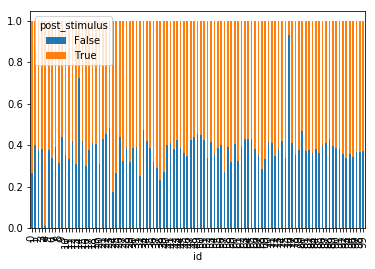

In [14]:
# TO do: consider getting rid of outliers with abnormal post_stimulus % (should be around 50%)
pre_post_pcts.unstack().plot(kind='bar', stacked=True)

In [ ]:
"""
Use cases: 

1) NLP data
2) Sensor data, https://archive.ics.uci.edu/ml/datasets/Gas+sensors+for+home+activity+monitoring#

"""

In [ ]:
"""
!!! USE CASE 2 SHOWN BELOW !!!
"""

In [ ]:
# As a first POC for the HMM-based activity recognition, use only the post-stimulus measurements.

# todo: Discard measurements that obviously too short (likelihood of less than <<)

In [830]:
data_hmm = dataset_merged.loc[dataset_merged.time >= 0, 
                              [c for c in dataset_merged.columns if c not in 
                               ["date", "t0", "dt", "begin_time", "post_stimulus"]]
                             ]

print(data_hmm.shape)

(586570, 13)


In [150]:
data_hmm.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp.,Humidity,class
3429,0.0,0.000021,12.8102,10.3665,10.4529,11.6742,13.4941,13.2749,8.30531,9.04553,26.4234,59.4725,banana
3430,0.0,0.000309,12.8097,10.3655,10.4523,11.6734,13.4934,13.2740,8.30527,9.04545,26.4241,59.4745,banana
3431,0.0,0.000587,12.8088,10.3645,10.4516,11.6731,13.4930,13.2730,8.30523,9.04538,26.4246,59.4763,banana
3432,0.0,0.000865,12.8080,10.3638,10.4508,11.6727,13.4922,13.2719,8.30520,9.04516,26.4251,59.4779,banana
3433,0.0,0.001144,12.8078,10.3628,10.4503,11.6722,13.4914,13.2708,8.30517,9.04511,26.4256,59.4793,banana


In [ ]:
"""
Divide the dataset into train and holdout sets, 
where train is used to estimate the HMM parameters,
and holdout will be used to quantify the accuracy of the subsequent estimation. 

Stratified sample over stimulus types. 

See how validation improves with increased training data. 
"""

In [16]:
data_hmm.groupby("class")["id"].nunique()

class
background    30
banana        33
wine          36
Name: id, dtype: int64

In [831]:
# todo: experiment with perturbing these
min_sample_length = 0
max_sample_length = np.float("inf")

max_samples_per_class = 20

In [832]:
train_ids = metadata.groupby("class")["id"].apply(lambda x: x.sample(n = max_samples_per_class, 
                                                                     random_state = MY_SEED))

In [834]:
holdout_data = metadata.loc[~metadata.id.isin(train_ids.values), ["class", "id"]]

In [835]:
holdout_ids = holdout_data.groupby("class")["id"].apply(lambda x: x.sample(n = 10, random_state = MY_SEED))

In [836]:
train_ids.rename_axis(index=["class", "id"], inplace=True)
holdout_ids.rename_axis(index=["class", "id"], inplace=True)

In [837]:
train_ids[train_ids > -1] = "train"
holdout_ids[holdout_ids > -1] = "holdout"

In [838]:
train_holdout_label = pd.concat([train_ids, holdout_ids])

In [839]:
train_holdout_label.name = "train_holdout"

In [840]:
data_hmm = pd.merge(data_hmm, train_holdout_label, how="left", on=["class", "id"])

In [ ]:
"""
WHOOPS my observation variables are continuous - should I use a particle filter? Or I could bin them. 

Trying the HMM with binning first.
TODO Secondly, will try a particle filter.
"""

In [841]:
# Investigate how to cut the bins for each of the continuous observation variables. 
# Use k equal width bins, after discarding the most extreme 2% from each tail of the distribution 
# (mitigate influence of outliers). 

bin_ct_discretize = 5 # 10
cap_extreme_pct = .02  # between 0 and 1

vars_to_discretize = ["R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8", "Temp.", "Humidity"]
vars_binned = ["_".join((v, "binned")) for v in vars_to_discretize] 

In [842]:
%%time
# 5.63s
for var in vars_to_discretize:
    var_data = data_hmm[[var]]
    # Create the histogram
    cap_low = np.percentile(var_data, cap_extreme_pct * 100)
    cap_high = np.percentile(var_data, (1 - cap_extreme_pct) * 100)
    var_data.loc[(var_data < cap_low).values.flatten()] = cap_low
    var_data.loc[(var_data > cap_high).values.flatten()] = cap_high
    data_hmm[var + "_binned"] = pd.cut(var_data.values.flatten(), bin_ct_discretize, labels=False)

/Volumes/LaCie/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Volumes/LaCie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Volumes/LaCie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 3.09 s, sys: 979 ms, total: 4.06 s
Wall time: 5.91 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a204c32b0>,
      dtype=object)

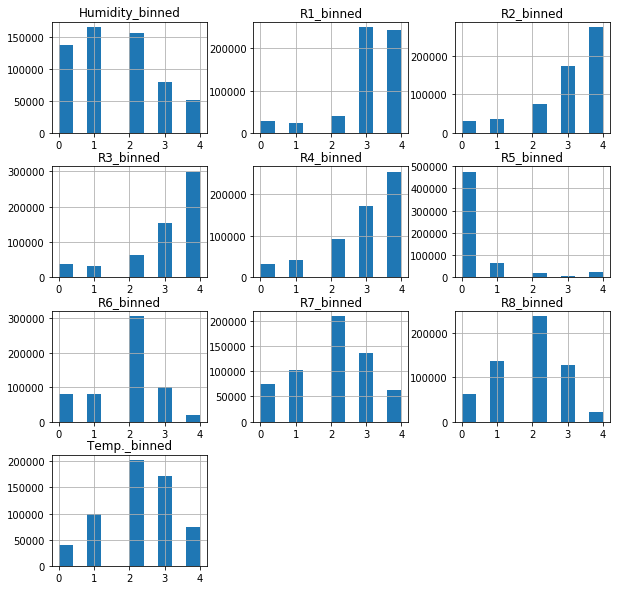

In [843]:
data_hmm[vars_binned].hist(figsize=(10,10))

In [844]:
data_hmm_discrete = data_hmm[["id", "class", "time", "train_holdout"] + vars_binned]
data_hmm_discrete.head()

,id,class,time,train_holdout,R1_binned,R2_binned,R3_binned,R4_binned,R5_binned,R6_binned,R7_binned,R8_binned,Temp._binned,Humidity_binned
0,0,banana,0.000021,train,4,4,4,4,0,1,4,4,1,2
1,0,banana,0.000309,train,4,4,4,4,0,1,4,4,1,2
2,0,banana,0.000587,train,4,4,4,4,0,1,4,4,1,2
3,0,banana,0.000865,train,4,4,4,4,0,1,4,4,1,2
4,0,banana,0.001144,train,4,4,4,4,0,1,4,4,1,2


In [845]:
data_hmm_train = \
data_hmm_discrete.loc[data_hmm_discrete.train_holdout == "train", [c for c in data_hmm_discrete.columns if c != "train_holdout"]]

data_hmm_holdout = \
data_hmm_discrete.loc[data_hmm_discrete.train_holdout == "holdout", [c for c in data_hmm_discrete.columns if c != "train_holdout"]]

In [ ]:
"""
THIS SECTION BUILDS OUT THE HMM CLASS FROM SCRATCH.
"""

In [ ]:
"""
Learn the parameters of an HMM (transition probabilities; emission probabilities).
Make assumption about prior probabilities of start state? Seems uniform is assumed by default. 

Maximum likelihood; using Baum-Welch (local maximum) or MCMC. 
Also approximate variational inference (slightly less accurate than MCMC, but better computational complexity). 

Note, the sensor process suits the stationary markov assumptions well. 
The discrete state space suits an HMM. 
Note though that the state will be static, so we need only model the emission probabilities. 
I guess we don't know the state is static though- can we detect this?

Follow-up:
If I splice different sequences together, can the HMM still differentiate amongst signals?
How about depending on how noisy is the splicing/frequency of transitions?

If I did this I suspect the HMM would fail, as transitions are essentially random.
Now, if I included both pre/post stimulus and included 'time' as a state variable it should be possible.
"""

In [554]:
# Multilevel HMM estimation
"""
Should make 2 classes, one for discrete obs vectors and one for continuous, 
then use inheritance from a master HMM class?

But may have a mix of discrete and continuous vectors... I'll ignore that case for now, 
implementation seems complicated. 

OO Implement multiple B matrices for the discrete case as well. 
Multiply probability of seeing obs given hidden state, across all obs sequences of different types/sensors
(assuming sequences are independent).

...What about modeling concatenation of multiple disparate continuous signals??
Multivariate mixtures of gaussians?
Fit a GMM for each separate observation dimension (ie multiple B matrices)

"""

class hmm_multi_discrete():
    """
    Assume HMM observations Y and hidden states X (both discrete and finite).
    A = transition probabilities; a_ij = prob X_t = j given X_t-1 = i
    B = emission probabilities; b_j(y_i) = prob Y_t = y_i given X_t = j
    pi = initial state distribution; pi_i = prob X_1 = i
    
    alpha_i(t) = Probability of observation sequence y_1 to y_t and state X_t = i at time t given current HMM parameters
    beta_i(t) = Probability of observation sequence y_t+1 to y_T given X_t = i and current HMM parameters
    
    Baum-Welch finds a local maximum.
    Implemented according to https://en.wikipedia.org/wiki/Baum–Welch_algorithm
    Followed Rabiner's HMM Tutorial on scaling the calculations (forward, backward)
    or using the log domain (Viterbi) to avoid numerical underflow. 
    
    As-is, the code is extended to multiple sequences of the same type. 
    To do: To extend to multiple observation sequences of different types (sensor fusion), 
    need to learn multiple B matrices!
    I want the sequences to share the A matrix, though this might not result in significant increased accuracy.
    It shouldn't hurt though, and it should be more computationally efficient. 
    
    Alternatively, for multiple sequences of different types, can I just run k different HMMs and average results?
    
    An obvious 3rd option would be to take the cross-product of the emission spaces of the multiple
    different types of sensors and treat that as a single sensor. However, this may suffer from 
    data sparsity issues. 
    If sparsity isn't an issue however, it would be more accurate than the above methods as it removes
    the assumption about independence among sensor types. 
    The existing code is already sufficient to handle this approach. Going with this as a first approach. 
    Desire further testing amongst the 3 methods. 
    """
    def __init__(self, A, B, pi):
        """
        A, B, pi numpy arrays
        A (size of X, size of X); A_ij = transition from x_i to x_j
        B (num sensors, size of X, size of Y); B_ij = prob observe y_j given x_i
        pi (size of X, 1)
        """
        self.A = A
        self.B = B
        self.pi = pi
        self.num_states = A.shape[0]
        self.num_sensors = B.shape[0]  # Assuming this isn't large enough to cause underflow
        self.num_emissions = B.shape[2]  # Assuming this is the same for all sensors (ie, quantized)
        
    def forward(self, y_vector):
        """
        Calculates alpha_i(t) for all states i, and all t. Filtering. 
        y_vector numpy array (num sensors, num emissions)
        Returns numpy array (T, num states); each row represents alpha_i(t) for 1< t<T
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("fwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in forward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            alpha_prev = np.multiply(self.pi, np.prod([self.B[s, :, y_vector[s, 0]] for s in range(self.num_sensors)], 
                                                      axis=0).reshape(self.num_states, 1))
            result = alpha_prev.copy().T  # one entry for each time t
            for h in range(1, t):
#                 print(alpha_prev, h)
                alpha_prev = np.multiply(np.dot(self.A.T, alpha_prev), 
                                         np.prod([self.B[s, :, y_vector[s, h]] for s in range(self.num_sensors)], 
                                                 axis=0).reshape(self.num_states, 1))
                alpha_prev = np.divide(alpha_prev, np.sum(alpha_prev))  # scaled version
                result = np.vstack((result, alpha_prev.T))
            return result
    
    def backward(self, y_vector, t_past):
        """
        Calculates beta_i(t) for all states i.
        y_vector numpy array (num sensors, num emissions)
        t_past integer representing past time ending the backward algorithm
        Returns numpy array (T, num states); each row represents beta_i(t) for 1< t<T.
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("bwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in backward algorithm")
            return None
        if t_past < 0 or t_past > t:
            print("Error: invalid t_past in backward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            beta_next = np.ones((self.num_states, 1))
            result = beta_next.copy().T
            for h in range(t - 2, t_past - 1, -1):
#                 print(beta_next, h)
                beta_next = np.dot(self.A, 
                                   np.multiply(np.prod([self.B[s, :, y_vector[s, h + 1]] 
                                                        for s in range(self.num_sensors)], 
                                                       axis=0).reshape(self.num_states, 1), 
                                               beta_next)
                                  )
                beta_next = np.divide(beta_next, np.sum(beta_next))
                result = np.vstack((result, beta_next.T))
            result = np.array(result[::-1])
            return result
    
    def forward_backward(self, y_vector):
        """
        Smoothing; Distribution over states of some middle latent variable, 
        at some point k steps in the past from time t.
        y_vector numpy array (num sensors, num emissions)
        Returns numpy array, (T x num_states)
        
        Note, this implementation has standard time complexity, but slightly higher 
        space complexity than the standard implementation which does not need to hold beta
        in memory. 
        """
        alpha = self.forward(y_vector)  # (T, num states)
        beta = self.backward(y_vector, 0)  # (T, num states); Compute beta for all possible t (1 to T)
        smoothed_estimates = np.multiply(alpha, beta)
        return smoothed_estimates
    
    def update_hmm(self, y_vector_arr):
        """
        Update the parameters of the HMM via one step of E-M Baum-Welch algorithm.
        y_vector_arr numpy_array corresponding to the sequences of observations.
        y_vector_arr (num_sensors, num_sequences, max time step observed so far)
        """
        # Assume have same number of sequences for each sensor
        # Separately for each observation sequence across all sensors, calculate intermediate variables gamma and xi.
        num_sequences = y_vector_arr.shape[1]
        num_obs_t = y_vector_arr.shape[2]
        
        if num_obs_t < 1:
            print("Error: Empty observation vector")
            return None
        
        results_gamma = []
        results_xi = []
        for r in range(num_sequences):
            y_vector = y_vector_arr[:, r, :]
            alpha = self.forward(y_vector)
            beta = self.backward(y_vector, 0)  # Compute beta for all possible t (1 to T)
        
            # Calculate for all i, j, and t:
            gamma_i = np.multiply(alpha, beta) # (T x num_states) 
            gamma_i = np.divide(gamma_i.T, np.sum(gamma_i, axis=1)).T # / (T); result is (T x num_states) 
            results_gamma.append(gamma_i)
            
            xi_agg_t = []
            for t in range(num_obs_t - 1):
                xi_ijt = np.multiply(
                    np.multiply(
                    np.multiply(self.A, alpha[t, :].reshape(alpha.shape[1], 1)),  # (num_states x num_states)
                    beta[t + 1, :]),  # (num_states x num_states)
                    np.prod([self.B[s, :, y_vector[s, t + 1]] for s in range(self.num_sensors)], axis=0
                           ).reshape(1, self.num_states)  # (num_states x num_states)
#                     self.B[:, y_vector[t + 1]].reshape(1, self.B.shape[0])  # (num_states x num_states)
                    )   # (start_state, end_state)
                xi_ijt = xi_ijt / np.sum(xi_ijt)
                xi_agg_t.append(xi_ijt)
            xi_agg_t = np.array(xi_agg_t)  # (result is (T-1 x num_states x num_states))
            results_xi.append(xi_agg_t)
            
        results_gamma = np.array(results_gamma)  # result is (num_sequences x T x num_states) 
        results_xi = np.array(results_xi)  # (result is (num_sequences x T-1 x num_states x num_states))
                
        # Combining data across sequences, update the parameters of the HMM using the intermediate variables. 
        pi_new = np.sum(results_gamma[:, 0, :], axis=0).reshape(results_gamma.shape[2], 1) / num_sequences
        a_new = np.divide(np.sum(results_xi, axis=(0, 1)),
                          np.sum(results_gamma[:, :num_obs_t - 1, :], axis=(0, 1)).reshape(results_gamma.shape[2], 1)
                         )
        b_new = [[np.sum(
                [np.sum(results_gamma[r, [t for t in range(num_obs_t) if y_vector_arr[s, r, t] == k], 
                                      :].reshape(len([t for t in range(num_obs_t) if y_vector_arr[s, r, t] == k]), 
                                                         results_gamma.shape[2]), 
                         axis=0)  # (1 x num_states)
                 for r in range(num_sequences)], axis=0)  # (1 x num_states)
                 for k in range(self.num_emissions)]  # (num_emissions x num_states)
                 for s in range(self.num_sensors)]  # (num_sensors x num_emissions x num_states)
        b_new = np.array(b_new)
        b_new = np.divide(b_new,  # normalize
                          np.sum(results_gamma, axis=(0, 1)))  # (1 x num_states)
        b_new = np.moveaxis(b_new, 1, 2)  # (num_sensors x num_states x num_emissions)
        
        pi_change = np.subtract(self.pi, pi_new)
        A_change = np.subtract(self.A, a_new)
        B_change = np.subtract(self.B, b_new)
        
        self.pi = pi_new
        self.A = a_new
        self.B = b_new
        
        return [pi_change, A_change, B_change]
    
    def fit(self, y_vector_arr, max_iter=100, conv_tol=0.01):
        """
        Fits the HMM with specified convergence criteria, using the EM-based update function, Baum-Welch. 
        
        y_vector_arr numpy array (num sensors, num sequences, num observations) of integers in [0, num_emissions]
        """
        num_obs_t = y_vector_arr.shape[2]
        if num_obs_t < 1:
            print("Error: Empty observation vector. Aborting fit.")
            return None
        
        num_iter = 0
        conv_diff = np.float("inf")
        while num_iter < max_iter and conv_diff > conv_tol:
            pi_change, A_change, B_change = self.update_hmm(y_vector_arr)
            conv_diff = max(pi_change.max(), A_change.max(), B_change.max())
            num_iter += 1
        print("%d iterations." %(num_iter))
        if conv_diff > conv_tol:
            print("Warning: Baum-Welch not converged at %3.2f." %(conv_tol), "Conv diff of %3.2f" %(conv_diff))
        return None
    
    def viterbi(self, y_vector_arr):
        """
        Probability of the latent variables:
        Most Likely Explanation; Joint probability of the entire sequence of hidden states 
        that generated an entire sequence of observations. 
        
        y_vector_arr numpy_array corresponding to the sequences of observations.
        y_vector_arr (num_sensors, num_sequences, max time step observed so far)
        
        Todo: How does this extend to multiple observation sequences? 
        It seems consider all sequences at each step when running forward through time. 
        Maybe, take the maximal previous state across the product of all sequences, such that
        decoded sequence may not be the viterbi solution for any individual sequence. 
        Or, use the product of the sequences (going with this).
        
        This assumes sequences are independent, and gives equal importance/weight to each sequence.
        Equal weight might not be the best idea if different sequences have different noise levels/
        accuracy. 
        Todo: flexible weights, in this function and throughout class. 
        Alternatively, first PCA/ICA transform the sequences. (Perhaps a better idea? 
        Otherwise, the estimation of relative noise levels for each sequence would be manual/
        judgmental process)
        Still nice to have a manual over-ride. 
        """
        num_obs_t = y_vector_arr.shape[2]
        if num_obs_t < 1:
            print("Error: Empty observation vector in viterbi algorithm")
            return None
        else:
            # Dynamic programming 
            # Maximal prior sequence given current evidence, conditioned on current state
            # Note: to extent to multiple sequences of different types, need to learn different B matrices!
            alpha_prev = np.multiply(self.pi, 
                                     np.prod([self.B[s, :, y_vector_arr[s, :, 0]] 
                                              for s in range(self.num_sensors)], axis=0))  # (num_states x num_seq)
#                                      self.B[:, y_vector_arr[:, 0]])  # (num_states x num_seq)
            alpha_prev = np.log(np.prod(alpha_prev, axis=1).reshape(self.num_states, 1))  # aggregate across sequences
            result = alpha_prev.copy().T  # one entry for each time t
            for h in range(1, num_obs_t):
                alpha_prev_new = np.prod([self.B[s, :, y_vector_arr[s, :, h]] 
                                          for s in range(self.num_sensors)], axis=(0, 1)).reshape(1, self.num_states)
#                 alpha_prev_new = np.prod(self.B[:, y_vector_arr[:, h]], axis=1).reshape(1, self.B.shape[0])
                alpha_prev = np.add(np.max(np.add(np.log(self.A), alpha_prev), axis=0),  # (1 x num_states)
                                    np.log(alpha_prev_new)).T
                result = np.vstack((result, alpha_prev.T))
        # Backtrack and return the most likely sequence
        most_likely_seq = np.argmax(result, axis=1).tolist()
        return most_likely_seq

In [ ]:
# Multilevel HMM estimation
"""
!!! NOT UPDATED - IGNORE THIS CODE, IT'S THE SAME AS ABOVE, JUST RENAMED !!!
Continuous observation sequence version (GMM)

Resources:
Rabiner Tutorial
Gutierrez-Osuna, http://research.cs.tamu.edu/prism/lectures/sp/l14.pdf
"""

class hmm_multi_gmm():
    """
    Assume HMM observations Y and hidden states X (both discrete and finite).
    A = transition probabilities; a_ij = prob X_t = j given X_t-1 = i
    B = emission probabilities; b_j(y_i) = prob Y_t = y_i given X_t = j
    pi = initial state distribution; pi_i = prob X_1 = i
    
    alpha_i(t) = Probability of observation sequence y_1 to y_t and state X_t = i at time t given current HMM parameters
    beta_i(t) = Probability of observation sequence y_t+1 to y_T given X_t = i and current HMM parameters
    
    Baum-Welch finds a local maximum.
    Implemented according to https://en.wikipedia.org/wiki/Baum–Welch_algorithm
    Followed Rabiner's HMM Tutorial on scaling the calculations (forward, backward)
    or using the log domain (Viterbi) to avoid numerical underflow. 
    
    As-is, the code is extended to multiple sequences of the same type. 
    To do: To extend to multiple observation sequences of different types (sensor fusion), 
    need to learn multiple B matrices!
    I want the sequences to share the A matrix, though this might not result in significant increased accuracy.
    It shouldn't hurt though, and it should be more computationally efficient. 
    
    Alternatively, for multiple sequences of different types, can I just run k different HMMs and average results?
    
    An obvious 3rd option would be to take the cross-product of the emission spaces of the multiple
    different types of sensors and treat that as a single sensor. However, this may suffer from 
    data sparsity issues. 
    If sparsity isn't an issue however, it would be more accurate than the above methods as it removes
    the assumption about independence among sensor types. 
    The existing code is already sufficient to handle this approach. Going with this as a first approach. 
    Desire further testing amongst the 3 methods. 
    """
    def __init__(self, A, B, pi):
        """
        A, B, pi numpy arrays
        A (size of X, size of X); A_ij = transition from x_i to x_j
        B (num sensors, size of X, size of Y); B_ij = prob observe y_j given x_i
        pi (size of X, 1)
        """
        self.A = A
        self.B = B
        self.pi = pi
        self.num_states = A.shape[0]
        self.num_sensors = B.shape[0]  # Assuming this isn't large enough to cause underflow
        self.num_emissions = B.shape[2]  # Assuming this is the same for all sensors (ie, quantized)
        
    def forward(self, y_vector):
        """
        Calculates alpha_i(t) for all states i, and all t. Filtering. 
        y_vector numpy array (num sensors, num emissions)
        Returns numpy array (T, num states); each row represents alpha_i(t) for 1< t<T
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("fwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in forward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            alpha_prev = np.multiply(self.pi, np.prod([self.B[s, :, y_vector[s, 0]] for s in range(self.num_sensors)], 
                                                      axis=0).reshape(self.num_states, 1))
            result = alpha_prev.copy().T  # one entry for each time t
            for h in range(1, t):
#                 print(alpha_prev, h)
                alpha_prev = np.multiply(np.dot(self.A.T, alpha_prev), 
                                         np.prod([self.B[s, :, y_vector[s, h]] for s in range(self.num_sensors)], 
                                                 axis=0).reshape(self.num_states, 1))
                alpha_prev = np.divide(alpha_prev, np.sum(alpha_prev))  # scaled version
                result = np.vstack((result, alpha_prev.T))
            return result
    
    def backward(self, y_vector, t_past):
        """
        Calculates beta_i(t) for all states i.
        y_vector numpy array (num sensors, num emissions)
        t_past integer representing past time ending the backward algorithm
        Returns numpy array (T, num states); each row represents beta_i(t) for 1< t<T.
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("bwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in backward algorithm")
            return None
        if t_past < 0 or t_past > t:
            print("Error: invalid t_past in backward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            beta_next = np.ones((self.num_states, 1))
            result = beta_next.copy().T
            for h in range(t - 2, t_past - 1, -1):
#                 print(beta_next, h)
                beta_next = np.dot(self.A, 
                                   np.multiply(np.prod([self.B[s, :, y_vector[s, h + 1]] 
                                                        for s in range(self.num_sensors)], 
                                                       axis=0).reshape(self.num_states, 1), 
                                               beta_next)
                                  )
                beta_next = np.divide(beta_next, np.sum(beta_next))
                result = np.vstack((result, beta_next.T))
            result = np.array(result[::-1])
            return result
    
    def forward_backward(self, y_vector):
        """
        Smoothing; Distribution over states of some middle latent variable, 
        at some point k steps in the past from time t.
        y_vector numpy array (num sensors, num emissions)
        Returns numpy array, (T x num_states)
        
        Note, this implementation has standard time complexity, but slightly higher 
        space complexity than the standard implementation which does not need to hold beta
        in memory. 
        """
        alpha = self.forward(y_vector)  # (T, num states)
        beta = self.backward(y_vector, 0)  # (T, num states); Compute beta for all possible t (1 to T)
        smoothed_estimates = np.multiply(alpha, beta)
        return smoothed_estimates
    
    def update_hmm(self, y_vector_arr):
        """
        Update the parameters of the HMM via one step of E-M Baum-Welch algorithm.
        y_vector_arr numpy_array corresponding to the sequences of observations.
        y_vector_arr (num_sensors, num_sequences, max time step observed so far)
        """
        # Assume have same number of sequences for each sensor
        # Separately for each observation sequence across all sensors, calculate intermediate variables gamma and xi.
        num_sequences = y_vector_arr.shape[1]
        num_obs_t = y_vector_arr.shape[2]
        
        if num_obs_t < 1:
            print("Error: Empty observation vector")
            return None
        
        results_gamma = []
        results_xi = []
        for r in range(num_sequences):
            y_vector = y_vector_arr[:, r, :]
            alpha = self.forward(y_vector)
            beta = self.backward(y_vector, 0)  # Compute beta for all possible t (1 to T)
        
            # Calculate for all i, j, and t:
            gamma_i = np.multiply(alpha, beta) # (T x num_states) 
            gamma_i = np.divide(gamma_i.T, np.sum(gamma_i, axis=1)).T # / (T); result is (T x num_states) 
            results_gamma.append(gamma_i)
            
            xi_agg_t = []
            for t in range(num_obs_t - 1):
                xi_ijt = np.multiply(
                    np.multiply(
                    np.multiply(self.A, alpha[t, :].reshape(alpha.shape[1], 1)),  # (num_states x num_states)
                    beta[t + 1, :]),  # (num_states x num_states)
                    np.prod([self.B[s, :, y_vector[s, t + 1]] for s in range(self.num_sensors)], axis=0
                           ).reshape(1, self.num_states)  # (num_states x num_states)
#                     self.B[:, y_vector[t + 1]].reshape(1, self.B.shape[0])  # (num_states x num_states)
                    )   # (start_state, end_state)
                xi_ijt = xi_ijt / np.sum(xi_ijt)
                xi_agg_t.append(xi_ijt)
            xi_agg_t = np.array(xi_agg_t)  # (result is (T-1 x num_states x num_states))
            results_xi.append(xi_agg_t)
            
        results_gamma = np.array(results_gamma)  # result is (num_sequences x T x num_states) 
        results_xi = np.array(results_xi)  # (result is (num_sequences x T-1 x num_states x num_states))
                
        # Combining data across sequences, update the parameters of the HMM using the intermediate variables. 
        # todo: Do I have to divide out the scale factor, as in Errata to Rabiner? http://alumni.media.mit.edu/~rahimi/rabiner/rabiner-errata/rabiner-errata.html
        pi_new = np.sum(results_gamma[:, 0, :], axis=0).reshape(results_gamma.shape[2], 1) / num_sequences
        a_new = np.divide(np.sum(results_xi, axis=(0, 1)),
                          np.sum(results_gamma[:, :num_obs_t - 1, :], axis=(0, 1)).reshape(results_gamma.shape[2], 1)
                         )
        b_new = [[np.sum(
                [np.sum(results_gamma[r, [t for t in range(num_obs_t) if y_vector_arr[s, r, t] == k], 
                                      :].reshape(len([t for t in range(num_obs_t) if y_vector_arr[s, r, t] == k]), 
                                                         results_gamma.shape[2]), 
                         axis=0)  # (1 x num_states)
                 for r in range(num_sequences)], axis=0)  # (1 x num_states)
                 for k in range(self.num_emissions)]  # (num_emissions x num_states)
                 for s in range(self.num_sensors)]  # (num_sensors x num_emissions x num_states)
        b_new = np.array(b_new)
        b_new = np.divide(b_new,  # normalize
                          np.sum(results_gamma, axis=(0, 1)))  # (1 x num_states)
        b_new = np.moveaxis(b_new, 1, 2)  # (num_sensors x num_states x num_emissions)
        
        pi_change = np.subtract(self.pi, pi_new)
        A_change = np.subtract(self.A, a_new)
        B_change = np.subtract(self.B, b_new)
        
        self.pi = pi_new
        self.A = a_new
        self.B = b_new
        
        return [pi_change, A_change, B_change]
    
    def fit(self, y_vector_arr, max_iter=100, conv_tol=0.01):
        """
        Fits the HMM with specified convergence criteria, using the EM-based update function, Baum-Welch. 
        
        y_vector_arr numpy array (num sensors, num sequences, num observations) of integers in [0, num_emissions]
        """
        num_obs_t = y_vector_arr.shape[2]
        if num_obs_t < 1:
            print("Error: Empty observation vector. Aborting fit.")
            return None
        
        num_iter = 0
        conv_diff = np.float("inf")
        while num_iter < max_iter and conv_diff > conv_tol:
            pi_change, A_change, B_change = self.update_hmm(y_vector_arr)
            conv_diff = max(pi_change.max(), A_change.max(), B_change.max())
            num_iter += 1
        print("%d iterations." %(num_iter))
        if conv_diff > conv_tol:
            print("Warning: Baum-Welch not converged at %3.2f." %(conv_tol), "Conv diff of %3.2f" %(conv_diff))
        return None
    
    def viterbi(self, y_vector_arr):
        """
        Probability of the latent variables:
        Most Likely Explanation; Joint probability of the entire sequence of hidden states 
        that generated an entire sequence of observations. 
        
        y_vector_arr numpy_array corresponding to the sequences of observations.
        y_vector_arr (num_sensors, num_sequences, max time step observed so far)
        
        Todo: How does this extend to multiple observation sequences? 
        It seems consider all sequences at each step when running forward through time. 
        Maybe, take the maximal previous state across the product of all sequences, such that
        decoded sequence may not be the viterbi solution for any individual sequence. 
        Or, use the product of the sequences (going with this).
        TODO: This doesn't make sense if sequences are independent in time. They should be viterbi'd separately.
        
        This assumes sequences are independent, and gives equal importance/weight to each sequence.
        Equal weight might not be the best idea if different sequences have different noise levels/
        accuracy. 
        Todo: flexible weights, in this function and throughout class. 
        Alternatively, first PCA/ICA transform the sequences. (Perhaps a better idea? 
        Otherwise, the estimation of relative noise levels for each sequence would be manual/
        judgmental process)
        Still nice to have a manual over-ride. 
        """
        num_obs_t = y_vector_arr.shape[2]
        if num_obs_t < 1:
            print("Error: Empty observation vector in viterbi algorithm")
            return None
        else:
            # Dynamic programming 
            # Maximal prior sequence given current evidence, conditioned on current state
            # Note: to extent to multiple sequences of different types, need to learn different B matrices!
            alpha_prev = np.multiply(self.pi, 
                                     np.prod([self.B[s, :, y_vector_arr[s, :, 0]] 
                                              for s in range(self.num_sensors)], axis=0))  # (num_states x num_seq)
#                                      self.B[:, y_vector_arr[:, 0]])  # (num_states x num_seq)
            alpha_prev = np.log(np.prod(alpha_prev, axis=1).reshape(self.num_states, 1))  # aggregate across sequences
            result = alpha_prev.copy().T  # one entry for each time t
            for h in range(1, num_obs_t):
                alpha_prev_new = np.prod([self.B[s, :, y_vector_arr[s, :, h]] 
                                          for s in range(self.num_sensors)], axis=(0, 1)).reshape(1, self.num_states)
#                 alpha_prev_new = np.prod(self.B[:, y_vector_arr[:, h]], axis=1).reshape(1, self.B.shape[0])
                alpha_prev = np.add(np.max(np.add(np.log(self.A), alpha_prev), axis=0),  # (1 x num_states)
                                    np.log(alpha_prev_new)).T
                result = np.vstack((result, alpha_prev.T))
        # Backtrack and return the most likely sequence
        most_likely_seq = np.argmax(result, axis=1).tolist()
        return most_likely_seq

In [ ]:
def backward(y_vector, t_past):
        """
        Calculates beta_i(t) for all states i.
        y_vector numpy array (num sensors, num emissions)
        t_past integer representing past time ending the backward algorithm
        Returns numpy array (T, num states); each row represents beta_i(t) for 1< t<T.
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("bwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in backward algorithm")
            return None
        if t_past < 0 or t_past > t:
            print("Error: invalid t_past in backward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            beta_next = np.ones((num_states, 1))
            result = beta_next.copy().T
            for h in range(t - 2, t_past - 1, -1):
#                 print(beta_next, h)
                beta_next = np.dot(A, 
                                   np.multiply(np.prod([B[s, :, y_vector[s, h + 1]] 
                                                        for s in range(num_sensors)], 
                                                       axis=0).reshape(num_states, 1), 
                                               beta_next)
                                  )
                beta_next = np.divide(beta_next, np.sum(beta_next))
                result = np.vstack((result, beta_next.T))
            result = np.array(result[::-1])
            return result
        
def forward(y_vector):
        """
        Calculates alpha_i(t) for all states i, and all t. Filtering. 
        y_vector numpy array (num sensors, num emissions)
        Returns numpy array (T, num states); each row represents alpha_i(t) for 1< t<T
        
        To be computed separately for each sequence of observations Y_r.
        """
#         print("fwd")
        t = y_vector.shape[1]
        if t < 1:
            print("Error: Empty observation vector in forward algorithm")
            return None
        else:
            # Avoid recursion here because python has a hard recursion depth limitation; 
            # also, dynamic programming is more efficient. 
            # Probability observe y_h given were in state k previously, over all states k
            alpha_prev = np.multiply(pi, np.prod([B[s, :, y_vector[s, 0]] for s in range(num_sensors)], 
                                                      axis=0).reshape(num_states, 1))
            result = alpha_prev.copy().T  # one entry for each time t
            for h in range(1, t):
                print(alpha_prev, h)
                alpha_prev = np.multiply(np.dot(A.T, alpha_prev), 
                                         np.prod([B[s, :, y_vector[s, h]] for s in range(num_sensors)], 
                                                 axis=0).reshape(num_states, 1))
                alpha_prev = np.divide(alpha_prev, np.sum(alpha_prev))  # scaled version
                result = np.vstack((result, alpha_prev.T))
            return result

In [ ]:
"""
EXPERIMENTATION AND VALIDATION OF HMM CLASS
"""

In [ ]:
"""
TOY EXAMPLE, WIKIPEDIA CHICKEN/EGG
"""

In [569]:
# Test Case - wikipedia
# https://en.wikipedia.org/wiki/Baum–Welch_algorithm
A = np.array([[0.5, 0.5], [0.3, 0.7]])
B = np.array([[[0.3, 0.7], [0.8, 0.2]]])  # (num_sensors x num_states x num_emissions)
pi = np.array([[0.2], [0.8]])

# obs = np.array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]*100000])
obs = np.array([[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]]])  # (num_sensors x num_sequences x num_obs (T))
obs = np.array([[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]],  # Two sensors, one sequences
               [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]]])
obs = np.array([[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]], # Two sensors, two sequences
               [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]]
               ])

In [570]:
%%time
"""
After one iteration, updated HMM parameters should be:

A = np.array([[0.3973, 0.6027], 
              [0.1833, 0.8167]])
B = np.array([[0.0908, 0.9092], 
              [0.5752, 0.4248]])

"""

wiki_bw = hmm_multi_discrete(A, B, pi)

# N=0, E=1
wiki_bw.fit(obs, max_iter=30)

# Time complexity seems linear in T, as it should be (maybe factor of 6 for shorter, 3 for longer?)
# 10-length sequence: ~24 ms?
# 200-length sequence: <3 sec
# 10,000-length sequence: 7 min, 33s (453 sec)
# 100,000 length sequence: >5 hours...

21 iterations.
CPU times: user 72.5 ms, sys: 3.67 ms, total: 76.2 ms
Wall time: 82.8 ms


In [571]:
"""
array([[0.43921478, 0.56078522],
       [0.21445682, 0.78554318]])
       
array([[0.51577386, 0.48422614],
       [0.15197986, 0.84802014]])
"""
wiki_bw.A

array([[0.51577386, 0.48422614],
       [0.15197986, 0.84802014]])

In [572]:
"""
array([[0.46160107, 0.53839893],
       [0.91501557, 0.08498443]])
       
array([[6.62501454e-02, 9.33749855e-01],
       [9.99999961e-01, 3.91817883e-08]])
"""
wiki_bw.B
# Need to switch rows of B... Why??? And switch columns
# I think the code is right, though it doesn't agree with wikipedia. And my converged probabilities look right. 
# state 1 is egg-producing, state 2 is non-egg-producing
# obs 1 is no egg, obs2 is egg

array([[[6.62501454e-02, 9.33749855e-01],
        [9.99999961e-01, 3.91817883e-08]]])

In [573]:
"""
array([[0.07187023],
       [0.92812977]])
       
array([[1.87134381e-19],
       [1.00000000e+00]])
"""
wiki_bw.pi

array([[1.87134381e-19],
       [1.00000000e+00]])

In [575]:
# obs = [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
# State 2 ("1's") is non-egg producing, state 1 ("0's") is egg-producing
wiki_bw.viterbi(obs)

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

In [ ]:
"""
TODO (DONE?): MAKE THE FOLLOWING FUNCTIONS PART OF THE BAUM-WELCH CLASS AND RENAME CLASS TO HMM.
"""

In [ ]:
"""
Probability of an observed sequence

Using the forward algorithm (dynamic programming).
This is the same as the algorithm coded above; 
Sum over all i and select the last t. 
"""

In [ ]:
"""
Probability of the latent variables:
Filtering; Distribution over states of the last latent variable, given the observed sequence.

Using the forward algorithm (dynamic programming).
This is the same as the algorithm coded above; 
Select the last t, then normalize the resulting pseudo-probabilities. 
"""

In [ ]:
"""
Probability of the latent variables:
Smoothing; Distribution over states of some middle latent variable, at some point k steps in the past from time t.

Using the forward-backward algorithm.

Implemented above in HMM class.
"""

In [ ]:
"""
Probability of the latent variables:
Most Likely Explanation; Joint probability of the entire sequence of hidden states 
that generated an entire sequence of observations.  (ie, part of speech tagging)

Using Viterbi algorithm.

Implemented above in HMM class.
"""

In [ ]:
"""
MOX GAS SENSOR REAL-WORLD DATA EXPERIMENTATION/ACTIVITY RECOGNITION

Now apply class written above to the data_hmm, MOX gas sensor data prepared at the beginning of the notebook.
"""

In [495]:
data_hmm.shape

(586570, 24)

In [494]:
data_hmm.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,...,R1_binned,R2_binned,R3_binned,R4_binned,R5_binned,R6_binned,R7_binned,R8_binned,Temp._binned,Humidity_binned
0,0,0.000021,12.8102,10.3665,10.4529,11.6742,13.4941,13.2749,8.30531,9.04553,...,8,9,9,9,1,2,9,9,3,5
1,0,0.000309,12.8097,10.3655,10.4523,11.6734,13.4934,13.2740,8.30527,9.04545,...,8,9,9,9,1,2,9,9,3,5
2,0,0.000587,12.8088,10.3645,10.4516,11.6731,13.4930,13.2730,8.30523,9.04538,...,8,9,9,9,1,2,9,9,3,5
3,0,0.000865,12.8080,10.3638,10.4508,11.6727,13.4922,13.2719,8.30520,9.04516,...,8,9,9,9,1,2,9,9,3,5
4,0,0.001144,12.8078,10.3628,10.4503,11.6722,13.4914,13.2708,8.30517,9.04511,...,8,9,9,9,1,2,9,9,3,5


In [ ]:
# Emission space too large...

# Center and scale, then PCA/ICA on the obs sequences first to reduce them before binning?
# Then, use sensor fusion to linearly combine the disparate sequences into a single observation sequence

# To reduce length of sequences, could sample them at a certain frequency. 

# Hmm inference time complexity is O(T * |state space|^2)

In [ ]:
# Typically want to initialize B to some good guess (Rabiner)

# See 'Vector Quantization in Speech Encoding' Makhoul (1985) for codebook discretization
# Or can use continuous observation densities, say mixture of Gaussians (GMM) with a diagonal covariance matrix
# The latter will also help cut down on the number of parameters in my HMM...maybe

# Log-transform data to normalize it
# Fit a GMM for each separate observation dimension (ie multiple B matrices)

# Set minimum values in matrices A, B

In [ ]:
"""
Data prep
"""

In [ ]:
# Center and scale data

In [ ]:
# PCA

In [ ]:
# ICA

In [ ]:
# Deprecated: Sensor fuse

In [ ]:
# Log-transform and check normality

In [ ]:
# Optionally, bin/discretize data

In [ ]:
# Sample data

In [ ]:
"""
POC 0: Use binned raw data as discrete observation vector; sample data. 

POC 1: PCA/ICA centered and scaled obs sequences; log-transform; sample data
Apply as continuous observation vector.

POC 2: Same as POC 1 but bin/discretize (log-transformed) data, apply as discrete observation vector.
"""

In [ ]:
"""
POC 0 HMM
"""

In [ ]:
np.random.seed(MY_SEED)

In [1151]:
num_states_mox = 3  # background, wine, banana
num_emissions_mox = bin_ct_discretize  # binned into 10 deciles
num_sensors_mox = 10  # vars_binned
num_sequences = len(data_hmm.id.unique())  # 99

A_mox = np.full((num_states_mox, num_states_mox), 1./num_states_mox)

# HMM doesn't learn much with random uniform initialization
# B_mox = np.array([np.full((num_states_mox, num_emissions_mox), 1./num_emissions_mox)] * num_sensors_mox)
# With random initialization it learns!!
B_mox_temp = np.random.randint(1,10,(num_states_mox, num_emissions_mox))
B_mox = np.array([np.divide(B_mox_temp.T, np.sum(B_mox_temp, axis=1)).T] * num_sensors_mox)

pi_mox = np.full((num_states_mox, 1), 1./num_states_mox)

total_sampled_pts = 500000.0
target_window_size = 190  # Viterbi results are sensitive to this parameter
# I probably need to trade off width of window with # data points sampled

"""
Is it really appropriate to treat the different sensed experiments as independent observation sequences?
"""
# Subtract 1 to avoid running over end of sequence
num_ranges_per_seq = math.ceil(total_sampled_pts / target_window_size / num_sequences)

# Sample within sequences
data_hmm_seq = [data_hmm.loc[data_hmm.id == i, vars_binned + ["class"]].reset_index() for i in data_hmm.id.unique()]
sample_by_seq = [math.ceil(data_hmm_seq[i].shape[0] / num_ranges_per_seq) for i in range(num_sequences)]
# Don't want sampled windows to overlap
window_size_seq = [min(target_window_size, sample_by_seq[i]) for i in range(num_sequences)]

sampled_indexes_seq = [range(0, data_hmm_seq[i].shape[0], sample_by_seq[i]) for i in range(num_sequences)]
sampled_indexes_seq = [np.array([j for i in sampled_indexes_seq[k] for j in range(i, i + window_size_seq[k])]) 
                       for k in range(num_sequences)]
# Counter([len(sampled_indexes_seq[i]) for i in range(num_sequences)])
sampled_indexes_seq_len = \
Counter([len(sampled_indexes_seq[i]) for i in range(num_sequences)]).most_common(1)[0][0]
print("%d sequences dropped due to inconsistent sampling"
      %(len(Counter([len(sampled_indexes_seq[i]) for i in range(num_sequences)])) - 1))
# # Remove sequences that don't have mode # of sampled points (just a couple)
# data_hmm_seq = \
# data_hmm_seq[np.array([len(sampled_indexes_seq[i]) == sampled_indexes_seq_len for i in range(num_sequences)])]

# # Update for dropped sequences
# num_sequences = len(data_hmm_seq)

print("%d points sampled with target window size of %d; %d discrete ranges per sequence"
      %(total_sampled_pts, target_window_size, num_ranges_per_seq))

# Treat each id as a separate sequence!!! Sample within sequences 
# obs_mox = np.stack([data_hmm_seq[i].loc[sampled_indexes_seq[i], vars_binned].values for i in range(num_sequences)
#                    if len(sampled_indexes_seq[i]) == sampled_indexes_seq_len])
obs_min_len = 4000
obs_mox = np.stack([data_hmm_seq[i].loc[:obs_min_len, vars_binned].values for i in range(num_sequences)
                   if data_hmm_seq[i].shape[0] >= obs_min_len])   # Remove really short sequences
obs_mox = np.moveaxis(obs_mox, 2, 0)
# obs_mox = np.expand_dims(obs_mox, 1)  # (num_sensors, num_sequences, num_obs (T))
# sampled_true_states = np.stack([data_hmm_seq[i].loc[sampled_indexes_seq[i], ["class"]].values 
#                                 for i in range(num_sequences) 
#                                 if len(sampled_indexes_seq[i]) == sampled_indexes_seq_len])
sampled_true_states = np.stack([data_hmm_seq[i].loc[:obs_min_len, ["class"]].values 
                                for i in range(num_sequences) 
                                if data_hmm_seq[i].shape[0] >= obs_min_len])
sampled_true_states = np.squeeze(np.moveaxis(sampled_true_states, 2, 0))

print("Observation sequence sampling frequency of %3.2f%%"%(100 * total_sampled_pts / data_hmm.shape[0]))

22 sequences dropped due to inconsistent sampling
500000 points sampled with target window size of 190; 27 discrete ranges per sequence
Observation sequence sampling frequency of 85.24%


In [1152]:
obs_mox.shape

(10, 95, 4001)

In [1153]:
sampled_true_states.shape

(95, 4001)

In [1154]:
np.histogram(obs_mox)

(array([684359,      0, 541173,      0,      0, 915135,      0, 865216,
             0, 795067]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]))

In [1155]:
%%time

hmm_mox = hmm_multi_discrete(A_mox, B_mox, pi_mox)

# N=0, E=1
hmm_mox.fit(obs_mox, max_iter=30)
# 100K, 50 takes less iterations, same time as 50K-20, <2 min
# 400K, 500 takes <7 min for 5 iters
# 500K, 1500 takes 4 iters, 3 min, best viterbi results with more data
# 500K, 5000 takes 9 iterations, 40 sec
# Just take all data? Up to first 4000 pts (no sampling) takes 10 iterations, 12 min

# Too few iterations overall a sign learning isn't occurring?? actually too many sequences dropped above... 


10 iterations.
CPU times: user 12min 11s, sys: 4.35 s, total: 12min 15s
Wall time: 12min 18s


In [1156]:
"""
array([[0.98539741, 0.003499  , 0.01110359],
       [0.01953505, 0.97315361, 0.00731134],
       [0.00949344, 0.00310452, 0.98740204]])
"""
hmm_mox.A  # This is correct, actually

array([[9.99055184e-01, 9.44815908e-04, 1.87597371e-15],
       [9.43771483e-04, 9.98582526e-01, 4.73702071e-04],
       [1.00820934e-05, 4.13068077e-04, 9.99576850e-01]])

In [1157]:
hmm_mox.B[:2]  # This can't be verified, but it looks like learning is occurring

array([[[2.04179455e-001, 1.53857510e-001, 3.00588501e-001,
         3.05283680e-001, 3.60908546e-002],
        [4.95803632e-064, 3.90337462e-063, 6.94335286e-015,
         8.00271228e-001, 1.99728772e-001],
        [8.81627157e-165, 2.02127678e-175, 8.68998316e-090,
         2.06123665e-001, 7.93876335e-001]],

       [[2.38725531e-001, 2.43475509e-001, 3.52908081e-001,
         1.35965833e-001, 2.89250460e-002],
        [3.15699135e-016, 1.77278100e-002, 2.91904055e-002,
         8.57281051e-001, 9.58007337e-002],
        [1.71313919e-307, 7.29075914e-106, 7.59825554e-063,
         3.77991214e-010, 1.00000000e+000]]])

In [1158]:
hmm_mox.B[-2:]

array([[[0.09576075, 0.20130406, 0.34044187, 0.25236966, 0.11012366],
        [0.05002647, 0.11280368, 0.29961266, 0.28999965, 0.24755754],
        [0.0484409 , 0.14113284, 0.36284783, 0.38191467, 0.06566376]],

       [[0.19214693, 0.35163369, 0.25485963, 0.13181891, 0.06954084],
        [0.15446859, 0.25443011, 0.28102889, 0.20009486, 0.10997756],
        [0.28587163, 0.30460422, 0.26088416, 0.05937   , 0.08926999]]])

In [1159]:
hmm_mox.pi  # Nice! Sensible result after break apart sequences.

array([[0.14737445],
       [0.29615658],
       [0.55646897]])

In [1160]:
%%time
"""
Important: Viterbi independent sequences separately.
"""
inferred_states_mox = np.array([hmm_mox.viterbi(np.expand_dims(obs_mox[:,i,:], 1)) for i in range(obs_mox.shape[1])])

/Volumes/LaCie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:283: RuntimeWarning: divide by zero encountered in log
/Volumes/LaCie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:276: RuntimeWarning: divide by zero encountered in log


CPU times: user 26.3 s, sys: 167 ms, total: 26.5 s
Wall time: 26.5 s


In [1161]:
inferred_states_mox.shape

(95, 4001)

In [1162]:
inferred_states_mox_mc = [Counter(i).most_common(1)[0][0] for i in inferred_states_mox]

In [1163]:
sampled_true_states_mc = [Counter(i).most_common(1)[0][0] for i in sampled_true_states]  # uniform

In [1164]:
viterbi_results_hmm_mox = \
pd.merge(pd.DataFrame(inferred_states_mox_mc, columns=["inferred_state"]), 
         pd.DataFrame(sampled_true_states_mc, columns=["true_state"]),
        left_index=True, right_index=True)

viterbi_results_hmm_mox = \
pd.merge(viterbi_results_hmm_mox, 
        pd.DataFrame(np.ones((viterbi_results_hmm_mox.shape[0], 1)), columns=["counts"]),
        left_index=True, right_index=True)

In [1165]:
"""
With more data, I seem to at least arrive at unimodal predictions of inferred state
"""
viterbi_results_hmm_mox.groupby(['true_state', 'inferred_state']).count()

counts
true_state inferred_state        
background 0                    1
           1                   10
           2                   18
banana     0                    8
           1                    8
           2                   16
wine       0                   25
           1                    5
           2                    4

In [ ]:
"""
POC 1 HMM
"""

In [ ]:
"""
POC 2 HMM

...Save for later? Parameter space may explode... 
I could try a semi-continuous GMHMM as described in Gutierrez-Osuna
"""

In [ ]:
"""
 Check we get the same result for POC 0 with the hmmlearn package
 
 Results as expected
"""

In [1206]:
from hmmlearn import hmm

# How to handle sensor fusion here??
# Not sure I'm handling this correctly
# https://github.com/hmmlearn/hmmlearn/issues/128

# X_mox = obs_mox[0,:,:].flatten()
X_mox = obs_mox.flatten()
X_mox = X_mox.reshape(X_mox.shape[0], 1)
lengths_mox = [obs_mox.shape[2]] * (obs_mox.shape[1] * obs_mox.shape[0])  # (10, 95, 4001)

In [1209]:
%%time
# 3x faster than my code

# model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# model = hmm.GMMHMM(n_components=3, covariance_type="full")
model = hmm.MultinomialHMM(n_components=3
#                            , n_features=num_emissions_mox
                          )

model.fit(X_mox, lengths_mox)

CPU times: user 4min 25s, sys: 2.23 s, total: 4min 27s
Wall time: 4min 45s


In [ ]:
# Check hmm fit parameters

In [1216]:
model.n_features  # correct

5

In [1217]:
model.startprob_  # reasonably intelligent, similar to mine

array([0.34308729, 0.29269944, 0.36421327])

In [1218]:
model.transmat_   # correct, same as as mine

array([[9.98652592e-01, 3.00350345e-04, 1.04705763e-03],
       [6.33247424e-04, 9.99366753e-01, 5.32124869e-38],
       [1.13262956e-03, 2.92946527e-39, 9.98867370e-01]])

In [1219]:
model.emissionprob_  # Just one B matrix... sad...

array([[4.41642198e-01, 5.91978136e-07, 4.07627128e-06, 5.58349265e-01,
        3.86868154e-06],
       [9.76141537e-33, 1.05028880e-34, 5.37377695e-33, 1.35527809e-05,
        9.99986447e-01],
       [1.26598923e-06, 3.71606414e-01, 6.28391042e-01, 1.27763654e-06,
        2.98557204e-36]])

In [ ]:
# Go on to validating predicted results via Viterbi

In [1210]:
sampled_true_states_mc_hmmlearn = sampled_true_states.flatten()

In [1221]:
%%time
# inferred_states_mox_mc_hmmlearn = model.predict(X_mox)
inferred_states_mox_mc_hmmlearn = model.decode(X_mox, algorithm="viterbi")

CPU times: user 2.4 s, sys: 397 ms, total: 2.79 s
Wall time: 2.87 s


In [1226]:
inferred_states_mox_mc_hmmlearn = inferred_states_mox_mc_hmmlearn[1]  # for decode

In [1227]:
inferred_states_mox_mc_hmmlearn.shape

(3800950,)

In [1230]:
viterbi_results_hmm_mox_hmmlearn = \
pd.merge(pd.DataFrame(inferred_states_mox_mc_hmmlearn, columns=["inferred_state"]), 
         pd.DataFrame(sampled_true_states_mc_hmmlearn, columns=["true_state"]),
        left_index=True, right_index=True)

viterbi_results_hmm_mox_hmmlearn = \
pd.merge(viterbi_results_hmm_mox_hmmlearn, 
        pd.DataFrame(np.ones((viterbi_results_hmm_mox_hmmlearn.shape[0], 1)), columns=["counts"]),
        left_index=True, right_index=True)

In [1231]:
# Like results for my code, results in terms of prediction aren't impressive
# My results are actually a bit more impressive (clearer clustering to mutually exclusive states),
# probably due to my handling of sensor fusion (independent sequences) versus complementary sequences. 
"""
# predict with decode

counts
true_state	inferred_state	
background	0	64989
1	50954
2	86
banana	0	43555
1	69934
2	14543
wine	0	74495
1	23054
2	38485
# decode with viterbi

same
"""
viterbi_results_hmm_mox_hmmlearn.groupby(['true_state', 'inferred_state']).count()


counts
true_state inferred_state        
background 0                64989
           1                50954
           2                   86
banana     0                43555
           1                69934
           2                14543
wine       0                74495
           1                23054
           2                38485